# Capstone Project - The Battle of the Neighborhoods
### Finding Location Options for a New Vegan Restaurant in Salt Lake City 
Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)


## Introduction <a name="introduction"></a>

### Background

According to a 2019 Gallup poll, about 5% of Americans consider themselves vegetarian, and 3% consider themselves vegan. Those numbers have remained nearly unchanged for the last 20 years. While there has not been an increase in people committing to a meat-free diet, almost 1 in 4 Americans have cut back on meat consumption. Most respondents cited health concerns as the reason for the reduction. [<sup>1</sup>](#fn1) 


Salt Lake City, UT is was recently named one of the ten best cities for vegetarians in America by Apartment Guide.  The city ranked number 7 and was noted for its strong vegan presence.[<sup>2</sup>](#fn2)   

### Business Problem

Since the demand for healthy, plant-based dining has increased, a local chef has decided to open a restaurant.  This project is focused on narrowing down locations options for opening a vegan restaurant in Salt Lake City, UT, USA. With a limited marketing budget, she wants to be in an area where her target market already frequents. The goal is to find available real estate in neighborhoods with the most vegan-friendly restaurants.


## Data <a name="data"></a>

The factors that will influence her decision are the number of vegan-friendly restaurants in each Salt Lake City neighborhood, paired with a current listing of commercial real estate. Three sources of data are required to complete the analysis:


- **Neighborhood Boundaries**
Under a Creative Commons license provided by Zillow, a GeoJSON file containing neighborhood location data for Salt Lake City, UT was downloaded from OpenDatasoft.com.  This data file contains the coordinates of the neighborhood boundaries.  With this information, neighborhoods will be assigned to the venues and real estate locations. [<sup>3</sup>](#fn3)
    
    
- **Vegan-Friendly Restaurant Data**
Through the use of the Foursquare API, a list of venues near Salt Lake City will be compiled.   The results contain the venue name, the latitude and longitude coordinates, and the venue category. [<sup>4</sup>](#fn4)
    
    
- **Available Commercial Real Estate Data**
CityFeet.com was scraped for available commercial real estate that could be suitable for a restaurant in the city.  The results contain the street address of the property, as well as the available square footage and price per square foot.[<sup>5</sup>](#fn5)


## Methodology <a name="methodology"></a>

### Libraries
The libaries required for data gathering and analysis are:


-Pandas:  Similar to the two-dimensional structure of a spread sheet, used to store and manipulate the data in a dataframe.
-	**Numpy**: Adds support for multi-dimensional arrays and matrices, along with high-level mathematical functions.
-	**JSON**: Used read and write JSON-encoded data.
-	**Geojson**: Functions for encoding and decoding GeoJSON formatted data
-	**Requests**: Used to send HTTP requests.
-	**BeautifulSoup**: Used to scrape data from websites.
-	**Geopandas**: Extends the datatypes used by pandas to allow spatial operations on geometric data.
-	**Shapely**: Used to perform geometric operations.
-	**Geopy**: Used to locate the coordinates of addresses.
-	**Pyproj**: Used to correctly place coordinate data at the appropriate location.
-	**Time**: Used to measure time of lapsed seconds to aid with request timeouts.
-	**Folium**: Used to create interactive maps.
-	**Matplotlib**: Used to plot charts to analyze data.


In [1]:
# Data handling
import pandas as pd
import numpy as np

# Data aquisition from web
from bs4 import BeautifulSoup 
import requests

# Location data transformation
import json
from pandas.io.json import json_normalize 
import geojson
import geopandas as gpd 
import geopandas.tools

from shapely.geometry import Point
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.exc import GeocoderTimedOut, GeocoderQuotaExceeded
from pyproj import CRS

#Data analysis and visulization
import time
import folium
from folium import plugins
from matplotlib import pyplot as plt

print("Libraries imported.")

Libraries imported.


### Data Aquisition and Cleaning

As mentioned previously, the sources of data include Zillow, Foursquare, and CityFeet.com. 

Zillow is a leading real estate marketplace and has compiled the boundaries for neighborhoods across the United States.  The company has made this information available on Opendatasoft.com.  The GeoJSON file for Salt Lake City was converted into a Geopandas dataframe to define the boundaries for each neighborhood.  The data remained unchanged.

Foursquare provided the list of vegan-friendly restaurants using the company's API.  Since a list of vegan-friendly restaurants is desired, the search term "vegan" was applied to all venues, rather than filtering for only restaurants that Foursquare categorizes as "Vegetarian / Vegan." The query returns a list of restaurants that may not cater specifically to vegans but offer vegan menu items, along with latitude and longitude coordinates.  The neighborhood of each venue was determined using the provided coordinates.  If a venue fell out of bounds of Salt Lake City, it was removed from the dataset.  Duplicate venues were also dropped, and the final venues dataframe was constructed.

CityFeet.com, a marketplace for commercial real estate, was scraped using BeautifulSoup to compile the available listings in Salt Lake City.  Rather than latitude and longitude coordinates, the street address was provided.  Geopy was used to find the latitude and longitude coordinates.  As with the venues, those coordinates were used to determine the neighborhood of the property listing. The search was focused on retail spaces in Salt Lake City, UT, but produced many results outside of the specified city.  Listings outside of the city's boundaries were removed, and the final listings dataframe was constructed.


### Data Exploration and Visualization
To understand where the vegan-friendly venues are located, the final venues dataframe was grouped by neighborhood and count.  Foursquare categorizes some venues as "Vegetarian / Vegan" if the restaurant chooses to serve only that type of cuisine.  A new dataframe with only this category was created to see if there is any difference in neighborhood locations between these restaurants and the ones who only have vegan options on their menus.  The distribution of both vegan-friendly and vegetarian/vegan specific restaurants was plotted has horizontal bar charts with Matplotlib.

The final listings dataframe was filtered to contain only listings from the top 3 neighborhoods from the venue counts.  A list of available properties within those neighborhoods was produced for the client.

To aid in visualizing where the property listings in relation to the neighborhoods, an interactive map is created using Folium.  A choropleth map shows where the highest concentrations of vegan-friendly restaurants are, and blue markers indicate the listings.  Neighborhood names are displayed when the user hovers over the area.  Clicking on the marker will identify the listing number.
 


#### Neighborhood Boundary Data 
The Zillow neighborhoods GeoJSON file was downloaded from OpenDatasoft.com.  To find the points for the boundaries, the file is obtained from its filepath.  Geopandas is used to read the file, which contains the following columns: city, name, regionid, county, state, and geometry.  The column "name" is changed to "Neighborhood" for clarity and the first five rows of the dataframe is displayed to check the input data.

In [2]:
slc_json = r"zillow-neighborhoods.geojson"
slc_json = gpd.read_file(slc_json)
slc_json.rename(columns = {'name':'Neighborhood'}, inplace = True) 

#Check input data
slc_json.head()

,city,Neighborhood,regionid,county,state,geometry
0,Salt Lake City,Jordan Meadows,416858,Salt Lake,UT,"POLYGON ((-111.95726 40.78486, -111.95712 40.7..."
1,Salt Lake City,Sugar House,240748,Salt Lake,UT,"POLYGON ((-111.83612 40.73362, -111.83544 40.7..."
2,Salt Lake City,Bonneville Hills,273002,Salt Lake,UT,"POLYGON ((-111.83068 40.75078, -111.83067 40.7..."
3,Salt Lake City,Greater Avenues,273875,Salt Lake,UT,"POLYGON ((-111.75997 40.85297, -111.75920 40.8..."
4,Salt Lake City,Yalecrest,276166,Salt Lake,UT,"POLYGON ((-111.84851 40.75075, -111.84702 40.7..."


\
\
In addition to verifying the coordinates are displayed in the dataframe above, a map is displayed to ensure the data accurately depicts the neighborhood boundaries of the city.

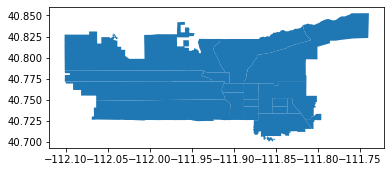

In [3]:
slc_json.plot()

#### Vegan-Friendly Restaurant Data
Using the Foursquare API, a list of vegan-friendly venues is obtained. The required credentials and search parameters are provided to abtain the search url.

In [4]:
CLIENT_ID = '<client id>' # Foursquare ID
CLIENT_SECRET = '<client secret>' # Foursquare Secret

In [59]:
# Geolocate Salt Lake City, UT
SLC = 'Salt Lake City, UT'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(SLC)
latitude = location.latitude
longitude = location.longitude

# Set additional search parameters 
VERSION = 20200401 # Foursquare API version
LIMIT = 1000
radius = 25000
search_query = 'Vegan'
near = "Salt Lake City, UT"

# Create URL for search
url = 'https://api.foursquare.com/v2/venues/explore?&near={}&client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
    near,
    CLIENT_ID, 
    CLIENT_SECRET, 
    latitude, 
    longitude, 
    VERSION, 
    search_query, 
    radius, 
    LIMIT)


\
\
The url is requested and a dataframe containing the venue data needed for the is displayed.


In [6]:
# Create JSON
results = requests.get(url).json()

# Assign relevant part of JSON to venues
venues_list=[]

results = requests.get(url).json()["response"]['groups'][0]['items']

# Tranform venues into a dataframe
venues_list.append([( 
    v['venue']['name'], 
    v['venue']['location']['lat'], 
    v['venue']['location']['lng'],  
     v['venue']['categories'][0]['name']) for v in results])

slc_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
slc_venues.columns = ['Venue', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category']
# Check dataframe
slc_venues.head()

,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,Buds,40.763001,-111.876332,Vegetarian / Vegan Restaurant
1,Zest Kitchen & Bar,40.763296,-111.896493,Vegetarian / Vegan Restaurant
2,Vertical Diner and the Jade Room,40.749944,-111.897866,Vegetarian / Vegan Restaurant
3,Sage's Cafe,40.762950,-111.877153,Vegetarian / Vegan Restaurant
4,Boltcutter,40.764733,-111.889396,Vegetarian / Vegan Restaurant


\
\
Since the Foursquare data could potentially change, a csv file is created to document the results at the time of this analysis.

In [7]:
slc_venues.to_csv("slc_venues.csv")

\
\
Using the venue data (slc_venues) and the neighborhood data (slc_json), the neighborhood for each venue is determined and placed in a new dataframe.

In [8]:
# Create a dataframe from venues' coordinates
venue_shp = pd.DataFrame(slc_venues, columns=["Venue", "Venue_Latitude", "Venue_Longitude"])

# Create the geometry column from the coordinates
venue_shp["geometry"] = venue_shp.apply(lambda row: Point(row["Venue_Longitude"], row["Venue_Latitude"]), axis=1)
del(venue_shp["Venue_Latitude"], venue_shp["Venue_Longitude"])

# Convert to a GeoDataFrame
venue_shp = geopandas.GeoDataFrame(venue_shp, geometry="geometry")

# Declare the coordinate system for the places GeoDataFrame
venue_shp.crs = "epsg:4326"

# Load the neighborhood polygons
neighborhoods = geopandas.GeoDataFrame.from_file("zillow-neighborhoods/zillow-neighborhoods.shp")

# Drop all columns except the name and polygon geometry
neighborhoods = neighborhoods[["name", "geometry"]]
neighborhoods.rename(columns = {'name':'Neighborhood'}, inplace = True) 


# Perform the spatial join
venue_neighborhoods = geopandas.tools.sjoin(venue_shp, neighborhoods, how="left")

# Check results
venue_neighborhoods.head()

,Venue,geometry,index_right,Neighborhood
0,Buds,POINT (-111.87633 40.76300),12.0,Central City
1,Zest Kitchen & Bar,POINT (-111.89649 40.76330),16.0,Downtown
2,Vertical Diner and the Jade Room,POINT (-111.89787 40.74994),14.0,People's Freeway
3,Sage's Cafe,POINT (-111.87715 40.76295),12.0,Central City
4,Boltcutter,POINT (-111.88940 40.76473),16.0,Downtown


\
\
The final_venues dataframe is created to merge the venue location and category data with the neighborhood data.  Since the Foursquare search produced a list of venues based on a radius around the center point of Salt Lake City, some results were actuall out of bounds.  Those results are dropped, along with any duplicates.

In [9]:
# Merge dataframes and keep only the necessary data
final_venues = pd.merge(slc_venues,venue_neighborhoods,on="Venue",how="outer")
final_venues = final_venues.drop_duplicates(subset=['geometry'])
final_venues = final_venues.drop_duplicates(subset=['Venue_Longitude'])
final_venues = final_venues.dropna(subset=['Neighborhood'])
final_venues.drop(final_venues.columns[[5]], axis=1, inplace=True)

# Check results
final_venues.head(10)

,Venue,Venue_Latitude,Venue_Longitude,Venue_Category,geometry,Neighborhood
0,Buds,40.763001,-111.876332,Vegetarian / Vegan Restaurant,POINT (-111.87633 40.76300),Central City
1,Zest Kitchen & Bar,40.763296,-111.896493,Vegetarian / Vegan Restaurant,POINT (-111.89649 40.76330),Downtown
2,Vertical Diner and the Jade Room,40.749944,-111.897866,Vegetarian / Vegan Restaurant,POINT (-111.89787 40.74994),People's Freeway
3,Sage's Cafe,40.762950,-111.877153,Vegetarian / Vegan Restaurant,POINT (-111.87715 40.76295),Central City
7,Boltcutter,40.764733,-111.889396,Vegetarian / Vegan Restaurant,POINT (-111.88940 40.76473),Downtown
8,All Chay,40.780476,-111.927444,Vegetarian / Vegan Restaurant,POINT (-111.92744 40.78048),Fairpark
9,Frisch,40.752187,-111.876604,Vegetarian / Vegan Restaurant,POINT (-111.87660 40.75219),Central City
10,Seasons Plant Based Bistro,40.740060,-111.888490,Vegetarian / Vegan Restaurant,POINT (-111.88849 40.74006),People's Freeway
11,CoreLife Eatery,40.768285,-111.890663,Vegetarian / Vegan Restaurant,POINT (-111.89066 40.76829),Downtown
16,Shanghai Cafe,40.741826,-111.886476,Vegetarian / Vegan Restaurant,POINT (-111.88648 40.74183),Central City-Liberty Wells


In [10]:
final_venues.to_csv("Final_Venues.csv")

#### Availiable Commercial Real Estate Data

To obtain a listing of available commerical real estate in Salt Lake City, the CityFeet.com url must be requested. For the url request to work, a user-agent needs to be defined. It will tell the website what type of browser and operating system is being used.  The url also filters the site's results to the city and type of spaces available for lease.

In [11]:
# Request url from CityFeet.com

headers = {
     "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.122 Safari/537.36",
}

page = requests.get("https://www.cityfeet.com/cont/salt-lake-city-ut/retail-space-for-lease", headers=headers) 

print("Done.")

Done.


\
\
Beautiful soup is used to scrape the search results from the website and a dataframe containing the street address, city, price per square foot, and size of the space is created.

In [12]:
# Use BeautifulSoup to parse data
soup = BeautifulSoup(page.text, "html.parser")
listings = soup.find(id="cf-col-1")
addresses = (listings.find_all(class_="prop-listing tabular"))

# Create lists of available addresses, corresponding city, price, and size information
address_list =  [item.find(class_="prop-listing-address").get_text() for item in addresses]
city_list =  [item.find(class_="prop-listing-city data-item").get_text() for item in addresses]
price_list =  [item.find(class_="price-item data-item non-premium").get_text() for item in addresses]
size_list =  [item.find(class_="size-desc non-premium data-item").get_text() for item in addresses]

# Create dataframe out of lists
all_listings = pd.DataFrame(
    {"StreetAddress" : address_list,
     "City" : city_list,
     "Price" : price_list,
     "Size" : size_list})

# Clean "\n" from listing data
all_listings = all_listings.replace("\n", "", regex = True)

# Check listing data
all_listings.head()

,StreetAddress,City,Price,Size
0,613 E 400 S,"Salt Lake City, UT 84102",$40.00 - $45.00 /Sq Ft/yr,"1,800 - 2,455 Sq Ft"
1,4411-4500 S 2950 E,"Salt Lake City, UT 84124",$15.00 /Sq Ft/yr,"3,000 Sq Ft"
2,2358-2364 S Main St,"Salt Lake City, UT 84115",$10.00 /Sq Ft/yr,"3,345 Sq Ft"
3,1107 S State St,"Salt Lake City, UT 84111",$10.00 /Sq Ft/yr,"3,485 Sq Ft"
4,917 S State St,"Salt Lake City, UT 84111",$16.00 /Sq Ft/yr,"3,400 Sq Ft"


\
\
Since the City Feet data could potentially change, a csv file is created to document the results at the time of this analysis.

In [13]:
all_listings.to_csv("all_listings.csv")

\
\
In order to determine the properties' neighboods, we need to obtain the latitude and longitude coordinates.  First, the street address and city are combined into one column.  Then the geoloaction data is obtained using the geopy library.

In [14]:
# Define function to combine Street Address and City columns into Full Address Column
def Full_Address(row):    
    return row['StreetAddress'] + ', ' + row['City'] 
      
all_listings['FullAddress'] = all_listings.apply(Full_Address, axis=1)

# Holds the Geocoding service, Nominatim
locator = Nominatim(user_agent="myGeocoder")  

# Geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
def geocode_me(location):
    time.sleep(1.1)
    try:
        return locator.geocode(location)
    except (GeocoderTimedOut, GeocoderQuotaExceeded) as e:
        if GeocoderQuotaExceeded:
            print(e)
        else:
            print(f'Location not found: {e}')
            return None

# Create location column
all_listings['location'] = all_listings['FullAddress'].apply(lambda x: geocode_me(x))  # ← note the change here

# Create longitude, latitude and altitude from location column (returns tuple)
all_listings['point'] = all_listings['location'].apply(lambda loc: tuple(loc.point) if loc else None)

# Split point column into latitude, longitude and altitude columns
all_listings[['latitude', 'longitude', 'altitude']] =   pd.DataFrame(all_listings['point'].tolist(), index=all_listings.index)

# Check results
all_listings.head()

,StreetAddress,City,Price,Size,FullAddress,location,point,latitude,longitude,altitude
0,613 E 400 S,"Salt Lake City, UT 84102",$40.00 - $45.00 /Sq Ft/yr,"1,800 - 2,455 Sq Ft","613 E 400 S, Salt Lake City, UT 84102","(613, 400 South, Central City, Salt Lake City,...","(40.7616473, -111.87329984837666, 0.0)",40.761647,-111.873300,0.0
1,4411-4500 S 2950 E,"Salt Lake City, UT 84124",$15.00 /Sq Ft/yr,"3,000 Sq Ft","4411-4500 S 2950 E, Salt Lake City, UT 84124",None,None,NaN,NaN,NaN
2,2358-2364 S Main St,"Salt Lake City, UT 84115",$10.00 /Sq Ft/yr,"3,345 Sq Ft","2358-2364 S Main St, Salt Lake City, UT 84115","(2358, Main Street, South Salt Lake, Salt Lake...","(40.71928499994709, -111.891222, 0.0)",40.719285,-111.891222,0.0
3,1107 S State St,"Salt Lake City, UT 84111",$10.00 /Sq Ft/yr,"3,485 Sq Ft","1107 S State St, Salt Lake City, UT 84111","(1107, State Street, Central City / Liberty-We...","(40.74499042857143, -111.888107, 0.0)",40.744990,-111.888107,0.0
4,917 S State St,"Salt Lake City, UT 84111",$16.00 /Sq Ft/yr,"3,400 Sq Ft","917 S State St, Salt Lake City, UT 84111","(917, South State Street, Porterville, Morgan ...","(41.01964058142246, -111.67505601295028, 0.0)",41.019641,-111.675056,0.0


\
\
To help make the properties easier to identify, a Listing ID is added.

In [15]:
# Add an ID number to identify listing
all_listings.insert(0, 'Listing_ID', range(100, 100 + len(all_listings)))

# Check results
all_listings.head()

,Listing_ID,StreetAddress,City,Price,Size,FullAddress,location,point,latitude,longitude,altitude
0,100,613 E 400 S,"Salt Lake City, UT 84102",$40.00 - $45.00 /Sq Ft/yr,"1,800 - 2,455 Sq Ft","613 E 400 S, Salt Lake City, UT 84102","(613, 400 South, Central City, Salt Lake City,...","(40.7616473, -111.87329984837666, 0.0)",40.761647,-111.873300,0.0
1,101,4411-4500 S 2950 E,"Salt Lake City, UT 84124",$15.00 /Sq Ft/yr,"3,000 Sq Ft","4411-4500 S 2950 E, Salt Lake City, UT 84124",None,None,NaN,NaN,NaN
2,102,2358-2364 S Main St,"Salt Lake City, UT 84115",$10.00 /Sq Ft/yr,"3,345 Sq Ft","2358-2364 S Main St, Salt Lake City, UT 84115","(2358, Main Street, South Salt Lake, Salt Lake...","(40.71928499994709, -111.891222, 0.0)",40.719285,-111.891222,0.0
3,103,1107 S State St,"Salt Lake City, UT 84111",$10.00 /Sq Ft/yr,"3,485 Sq Ft","1107 S State St, Salt Lake City, UT 84111","(1107, State Street, Central City / Liberty-We...","(40.74499042857143, -111.888107, 0.0)",40.744990,-111.888107,0.0
4,104,917 S State St,"Salt Lake City, UT 84111",$16.00 /Sq Ft/yr,"3,400 Sq Ft","917 S State St, Salt Lake City, UT 84111","(917, South State Street, Porterville, Morgan ...","(41.01964058142246, -111.67505601295028, 0.0)",41.019641,-111.675056,0.0


\
\
To get the neighborhood for each property listing, the same method that was used for venues is applied.

In [57]:
# Create a dataframe from listings' coordinates
listings_shp = pd.DataFrame(all_listings, columns=["Listing_ID", "StreetAddress", "latitude", "longitude"])

# Create the geometry column from the coordinates
listings_shp["geometry"] = listings_shp.apply(lambda row: Point(row["longitude"], row["latitude"]), axis=1)

# Convert to a GeoDataFrame
listings_shp = geopandas.GeoDataFrame(listings_shp, geometry="geometry")

# Declare the coordinate system for the places GeoDataFrame
listings_shp.crs = "epsg:4326"

# Perform the spatial join and drop any addresses out of bounds
final_listings = geopandas.tools.sjoin(listings_shp, neighborhoods, how="left")
final_listings = final_listings.dropna(subset=['Neighborhood']).reset_index()
final_listings.drop(final_listings.columns[[0,3,4,5,6]], axis=1, inplace=True)


# Check results
final_listings.head(50)

C:\Users\ErinPython\anaconda3\envs\geo-env\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


,Listing_ID,StreetAddress,Neighborhood
0,100,613 E 400 S,Central City
1,103,1107 S State St,People's Freeway
2,105,965 E 900 S,East Central
3,106,979 S State St,People's Freeway
4,109,6151-6191 S Highland Dr,Sugar House
5,110,161 W 900 S,Glendale
6,112,969 S 300 W,People's Freeway
7,117,3737 S 900 E,Sugar House
8,118,365 Paxton Ave,People's Freeway
9,120,122 S Main St,People's Freeway



## Analysis <a name="analysis"></a>

### Neighborhood Analysis

Using the final_venues dataframe, a new dataframe is created to count the number of venues in each neighborhood.  Unnecessary columns are dropped.  

In [37]:
venue_count = final_venues.groupby("Neighborhood").count().sort_values('Venue', ascending = False).reset_index()
venue_count.drop(venue_count.columns[[2,3,4,5,6]], axis=1, inplace=True)
venue_count.rename(columns = {'Venue':'Venue Count'}, inplace = True) 

venue_count

,Neighborhood,Venue Count
0,Downtown,13
1,Central City,12
2,People's Freeway,10
3,Sugar House,7
4,East Central,5
5,Central City-Liberty Wells,3
6,Liberty Wells,3
7,Westpointe,3
8,Fairpark,1
9,Jordan Meadows,1


\
\
The venue count by neighborhood table above indicates how many restuarants are in each neighborhood.  Ten neighborhoods are displayed, but out of how many total neighborhoods?

In [18]:
Total_Neighborhoods = len(slc_json)
Total_VF_Neighborhoods = len(venue_count)
print("Salt Lake City has a total of {} neighborhoods.".format(Total_Neighborhoods) +
      " Of those neighborhoods, {} of them have at least one vegan-friendly option.".format(Total_VF_Neighborhoods))
     

Salt Lake City has a total of 20 neighborhoods. Of those neighborhoods, 10 of them have at least one vegan-friendly option.


\
\
A column to indiate whether the venue is categorized as specifically vegetarian / vegan is added to the final_venues dataframe.

In [19]:
final_venues['Veg Only'] = np.where(final_venues["Venue_Category"] == 'Vegetarian / Vegan Restaurant', "yes", 'no')
final_venues.head()


,Venue,Venue_Latitude,Venue_Longitude,Venue_Category,geometry,Neighborhood,Veg Only
0,Buds,40.763001,-111.876332,Vegetarian / Vegan Restaurant,POINT (-111.87633 40.76300),Central City,yes
1,Zest Kitchen & Bar,40.763296,-111.896493,Vegetarian / Vegan Restaurant,POINT (-111.89649 40.76330),Downtown,yes
2,Vertical Diner and the Jade Room,40.749944,-111.897866,Vegetarian / Vegan Restaurant,POINT (-111.89787 40.74994),People's Freeway,yes
3,Sage's Cafe,40.762950,-111.877153,Vegetarian / Vegan Restaurant,POINT (-111.87715 40.76295),Central City,yes
7,Boltcutter,40.764733,-111.889396,Vegetarian / Vegan Restaurant,POINT (-111.88940 40.76473),Downtown,yes


\
\
A new dataframe is created to filter out restaurants that do not specifically cater to vegetarians or vegans.

In [20]:
veg_venues = final_venues[final_venues['Veg Only'] == "yes"]
veg_venues.head()


,Venue,Venue_Latitude,Venue_Longitude,Venue_Category,geometry,Neighborhood,Veg Only
0,Buds,40.763001,-111.876332,Vegetarian / Vegan Restaurant,POINT (-111.87633 40.76300),Central City,yes
1,Zest Kitchen & Bar,40.763296,-111.896493,Vegetarian / Vegan Restaurant,POINT (-111.89649 40.76330),Downtown,yes
2,Vertical Diner and the Jade Room,40.749944,-111.897866,Vegetarian / Vegan Restaurant,POINT (-111.89787 40.74994),People's Freeway,yes
3,Sage's Cafe,40.762950,-111.877153,Vegetarian / Vegan Restaurant,POINT (-111.87715 40.76295),Central City,yes
7,Boltcutter,40.764733,-111.889396,Vegetarian / Vegan Restaurant,POINT (-111.88940 40.76473),Downtown,yes


\
\
How many vegan-friendly restaurants are in Salt Lake City, and how many cater specifically to vegetarians and vegans?

In [21]:
Total_VF_Venues = len(final_venues)
Total_VO_Venues = len(veg_venues)

print("According to Foursquare, Salt Lake City has a total of {} vegan-friendly restaurants.".format(Total_VF_Venues) +
      " Of those restaurants, {} of them serve only vegetarian or vegan cuisine.".format(Total_VO_Venues))


According to Foursquare, Salt Lake City has a total of 58 vegan-friendly restaurants. Of those restaurants, 19 of them serve only vegetarian or vegan cuisine.


\
\
The distribution of vegan-friendly restuarants in each neighborhood is plotted.

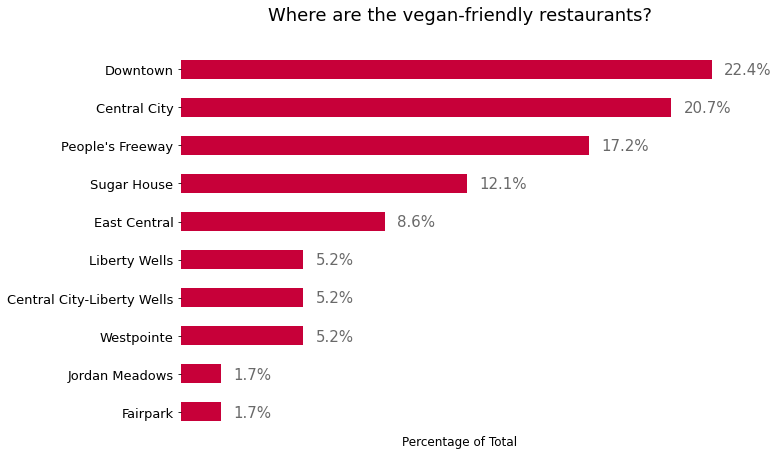

In [22]:
veg_friendly = final_venues['Neighborhood'].value_counts().plot(kind='barh', figsize=(10,7),
                                        color="#C70039", fontsize=13);
veg_friendly.set_alpha(0.8)
veg_friendly.set_title("Where are the vegan-friendly restaurants?", fontsize=18, pad=30)
veg_friendly.set_xlabel("Percentage of Total", fontsize=12);
veg_friendly.set_xticks([])
veg_friendly.spines['top'].set_visible(False)
veg_friendly.spines['right'].set_visible(False)
veg_friendly.spines['bottom'].set_visible(False)
veg_friendly.spines['left'].set_visible(False)

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in veg_friendly.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in veg_friendly.patches:
    # get_width pulls left or right; get_y pushes up or down
    veg_friendly.text(i.get_width()+.3, i.get_y()+.38, \
            str(round((i.get_width()/total)*100, 1))+'%', fontsize=15,
color='dimgrey')

# invert for largest on top 
veg_friendly.invert_yaxis()

\
\
The chart is saved as a png file.

In [23]:
veg_friendly.figure.tight_layout()
veg_friendly.figure.savefig('veg_friendly.png')


\
\
The distribution of vegetarian / vegan specific restuarants in each neighborhood is plotted.

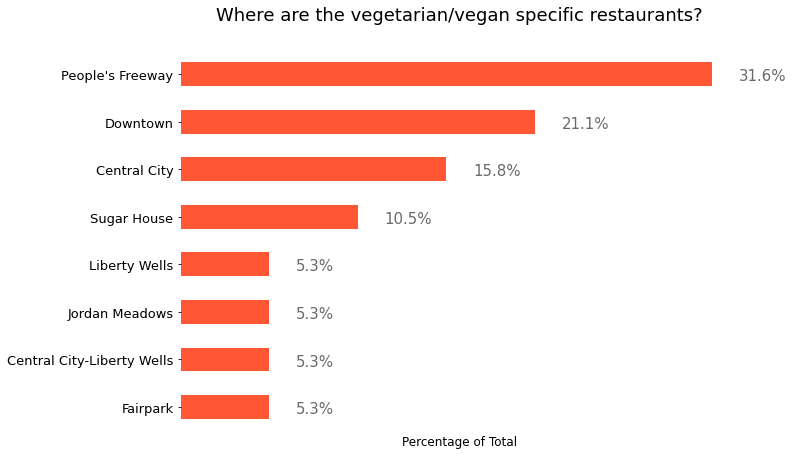

In [33]:
veg_only = veg_venues['Neighborhood'].value_counts().plot(kind='barh', figsize=(10,7),
                                        color="#ff5733", fontsize=13);
veg_only.set_alpha(0.8)
veg_only.set_title("Where are the vegetarian/vegan specific restaurants?", fontsize=18, pad=30)
veg_only.set_xlabel("Percentage of Total", fontsize=12);
veg_only.set_xticks([])
veg_only.spines['top'].set_visible(False)
veg_only.spines['right'].set_visible(False)
veg_only.spines['bottom'].set_visible(False)
veg_only.spines['left'].set_visible(False)

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in veg_only.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in veg_only.patches:
    # get_width pulls left or right; get_y pushes up or down
    veg_only.text(i.get_width()+.3, i.get_y()+.38, \
            str(round((i.get_width()/total)*100, 1))+'%', fontsize=15,
color='dimgrey')

# invert for largest on top 
veg_only.invert_yaxis()


\
\
The chart is saved as a png file.

In [34]:
veg_only.figure.tight_layout()
veg_only.figure.savefig('veg_only.png')


\
\
Though the distributions are slightly different in each chart, the top three neighborhoods are the same for both vegan-friendly and vegetarian / vegan only restaurants.  A new dataframe containg the top 3 neighborhoods is created to filter real estate listings.

In [26]:
top_3 = venue_count.nlargest(3, 'Venue Count')
top_3.drop(venue_count.columns[[1]], axis=1, inplace=True)

top_3

,Neighborhood
0,Downtown
1,Central City
2,People's Freeway


### Real Estate Listing Analysis

The total number of available commercial listings the final_listings dataframe is obtained.

In [27]:
Total_Listings = len(final_listings)

print("CityFeet.com has {} properties that may be suitable for lease within Salt Lake City.".format(Total_Listings))

CityFeet.com has 15 properties that may be suitable for lease within Salt Lake City.


\
\
The listings available in the top 3 neighborhoods is determined by filtering the final_listings dataframe to only the neighborhoods listed in the top_3 dataframe from above.

In [28]:
filtered_listings = final_listings[final_listings.set_index(['Neighborhood']).index.isin(top_3.set_index(['Neighborhood']).index)].reset_index(drop=True)

filtered_listings                                                                                                         

,Listing_ID,StreetAddress,latitude,longitude,Neighborhood
0,100,613 E 400 S,40.761647,-111.873300,Central City
1,103,1107 S State St,40.744990,-111.888107,People's Freeway
2,106,979 S State St,40.747625,-111.888108,People's Freeway
3,112,969 S 300 W,40.748109,-111.899555,People's Freeway
4,118,365 Paxton Ave,40.743399,-111.901477,People's Freeway
5,120,122 S Main St,40.756153,-111.890989,People's Freeway
6,126,110 W 900 S,40.749854,-111.894511,People's Freeway


\
\
A table with the listings in the selected neighborhoods with relavent listing information is prepared for the client.

In [29]:
listing_output = pd.merge(filtered_listings, all_listings,on="Listing_ID",how="inner")
listing_output.drop(listing_output.columns[[1,2,3,5,6,10,11,12,13,14]], axis=1, inplace=True)

listing_output.head(10)

,Listing_ID,Neighborhood,Price,Size,FullAddress
0,100,Central City,$40.00 - $45.00 /Sq Ft/yr,"1,800 - 2,455 Sq Ft","613 E 400 S, Salt Lake City, UT 84102"
1,103,People's Freeway,$10.00 /Sq Ft/yr,"3,485 Sq Ft","1107 S State St, Salt Lake City, UT 84111"
2,106,People's Freeway,$19.50 /Sq Ft/yr,"11,218 - 15,956 Sq Ft","979 S State St, Salt Lake City, UT 84111"
3,112,People's Freeway,$17.00 /Sq Ft/yr,"1,986 - 2,257 Sq Ft","969 S 300 W, Salt Lake City, UT 84101"
4,118,People's Freeway,$24.00 /Sq Ft/yr,"1,000 - 4,591 Sq Ft","365 Paxton Ave, Salt Lake City, UT 84101"
5,120,People's Freeway,$22.50 /Sq Ft/yr,"2,400 Sq Ft","122 S Main St, Salt Lake City, UT 84101"
6,126,People's Freeway,$26.50 /Sq Ft/yr,"1,204 - 1,962 Sq Ft","110 W 900 S, Salt Lake City, UT 84101"


### Interactive Map

Visualizing the locations of the real estate listings within the neighborhood boundaries may help the client in choosing which locations to furhter investigate. The geolocation data is added to the venue counts data in a new dataframe to aid in the creation of a choropleth map.

In [30]:
neighborhood_geo = pd.merge(venue_count, slc_json, on ='Neighborhood',how ='outer') 

neighborhood_geo.head()

,Neighborhood,Venue Count,city,regionid,county,state,geometry
0,Downtown,13.0,Salt Lake City,273488,Salt Lake,UT,"POLYGON ((-111.90248 40.76941, -111.90148 40.7..."
1,Central City,12.0,Salt Lake City,273199,Salt Lake,UT,"POLYGON ((-111.87822 40.76936, -111.87527 40.7..."
2,People's Freeway,10.0,Salt Lake City,275007,Salt Lake,UT,"POLYGON ((-111.91065 40.75803, -111.91017 40.7..."
3,Sugar House,7.0,Salt Lake City,240748,Salt Lake,UT,"POLYGON ((-111.83612 40.73362, -111.83544 40.7..."
4,East Central,5.0,Salt Lake City,273537,Salt Lake,UT,"POLYGON ((-111.85233 40.75303, -111.85233 40.7..."


\
\
A choropleth map to show the concentration of vegan-friendly restaurants by neighorhood is created using Folium.  Markers for the selected real estate listings are added to show where they fall in comparison.

In [31]:
threshold_scale = np.linspace(neighborhood_geo['Venue Count'].min(),
                              neighborhood_geo['Venue Count'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() 
threshold_scale[-1] = threshold_scale[-1] + 1 

slc_map = folium.Map(location=[40.7420, -111.8863], zoom_start=12)
choropleth = folium.Choropleth(
    geo_data=slc_json,
    data=neighborhood_geo,
    columns=['Neighborhood','Venue Count'],
    key_on='feature.properties.Neighborhood',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.6, 
    line_opacity=0.7,
    nan_fill_color= 'gray',
    highlight=True,
    legend_name='Vegan-Friendly Restaurants in Salt Lake City',
    smooth_factor=0,
    reset=True).add_to(slc_map)

choropleth.geojson.add_child(folium.features.GeoJsonTooltip(
        fields=['Neighborhood'],
        aliases=['Neighborhood:'],
        style=('background-color: white; color: black;'),
        localize=True
        )
)

# Create a marker for each school
for row in filtered_listings.iterrows():
    row_values = row[1]
    location = [row_values['latitude'], row_values['longitude']]
    popup = '<strong>' + 'Listing ID ' + '</strong>' + str(row_values['Listing_ID'])
    marker = folium.Marker(location = location, popup = popup)
    marker.add_to(slc_map)

slc_map

\
\
The map is saved as an html file.

In [32]:
slc_map.save('slc_map.html')



## Results and Discussion <a name="results"></a>

Upon narrowing down the top 3 neighborhoods, the property listings for available real estate shrink from 15 to 7 listings provided to the client.  Results of the analysis show that People's Freeway is the neighborhood with the most vegetarian/vegan restaurants and the most property listings.  While the goal of finding locations in the specified neighborhoods was met, the number of locations is limited.  



## Conclusion <a name="conclusion"></a>

The goal of this project was to find possible commercial real estate locations for a new vegan restaurant in Salt Lake City.  Since the client wants to be located near other vegan or vegan-friendly restaurants, the neighborhoods with the highest concentration of those types of restaurants were identified.  Available property listings in those neighborhoods were found.  Should the client not like the properties identified, the same process can be followed as listings update on the marketplace. 

## References

[<sup>1</sup>](#fn1)  McCarthy, J., & DeKoster, S. (2019, January 27). Nearly One in Four in U.S. Have Cut Back on Eating Meat. Retrieved April 30, 2020, from https://news.gallup.com/poll/282779/nearly-one-four-cut-back-eating-meat.aspx
    
[<sup>2</sup>](#fn2)  Carbarry, B. (2019, January 17). The 10 Best Cities for Vegetarians in America. Retrieved April 30, 2020, from https://www.apartmentguide.com/blog/best-cities-for-vegetarians/ 
    
[<sup>3</sup>](#fn3 )  Zillow - US Neighborhoods. (n.d.). Retrieved April 30, 2020, from https://data.opendatasoft.com/explore/dataset/zillow-neighborhoods@public/export/?refine.state=UT&refine.city=Salt+Lake+City&dataChart=eyJxdWVyaWVzIjpbeyJjb25maWciOnsiZGF0YXNldCI6InppbGxvdy1uZWlnaGJvcmhvb2RzQHB1YmxpYyIsIm9wdGlvbnMiOnsicmVmaW5lLnN0YXRlIjoiVVQiLCJyZWZpbmUuY2l0eSI6IlNhbHQgTGFrZSBDaXR5In19LCJjaGFydHMiOlt7ImFsaWduTW9udGgiOnRydWUsInR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiQ09VTlQiLCJzY2llbnRpZmljRGlzcGxheSI6dHJ1ZSwiY29sb3IiOiIjMTQyRTdCIn1dLCJ4QXhpcyI6InN0YXRlIiwibWF4cG9pbnRzIjo1MCwic29ydCI6IiJ9XSwidGltZXNjYWxlIjoiIiwiZGlzcGxheUxlZ2VuZCI6dHJ1ZSwiYWxpZ25Nb250aCI6dHJ1ZX0=
    
[<sup>4</sup>](#fn4)  Foursquare Developer. (n.d.). Retrieved April 30, 2020, from https://api.foursquare.com/

[<sup>5</sup>](#fn5)  Salt Lake City Retail For Lease. (n.d.). Retrieved April 30, 2020, from https://www.cityfeet.com/cont/salt-lake-city-ut/retail-space-for-lease

